**Name:** Siyu Xie

**Collaborator(s):** Matt, Celestine


# Studio 11 - The Folk Theorem

Gelman's [Folk Theorem of Statistical Computing](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/) states

> _"When you have computational problems, often there’s a problem with your model."_

This principle means that computational difficulties (slow convergence, sensitivity to initialization, getting stuck in local optima) can reflect genuine statistical issues (weak identifiability, overparameterization, insufficient data). Today we will see an example of this; along the way, we'll practice making an algorithm more efficient and numerically stable.

### Defining a Gaussian Mixture Model

A Gaussian Mixture Model (GMM) represents data as coming from a mixture of $K$ Gaussian distributions. The density of a GMM has the form:
$$p(\mathbf{x}) = \sum_{k=1}^K\pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k),$$
where
- $\pi_k$ are mixing proportions (with $\pi_k\ge 0$ and $\sum_{k=1}^K\pi_k = 1$)
- $\boldsymbol{\mu}_k \in \mathbb{R}^d$ are component means
- $\boldsymbol{\Sigma}_k \in \mathbb{R}^{d\times d}$ are component covariance matrices (must be positive definite)

We have a sample of observations $(x_i)_{i=1}^n$ and wish to estimate the parameters of the GMM.

### Latent Variable Interpretation

If $x_i$ is drawn from the GMM $p$, we can introduce a latent variable $z_i \in {1, 2, ..., K}$ that indicates which Gaussian distribution $\mathbf{x}_i$ came from, i.e.
- $p(z_i = k) = \pi_k$ (prior probability of component k)
- $p(\mathbf{x}_i | z_i = k) = \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ (likelihood given component)

If we knew the $z_i$ values, parameter estimation would be easy: just compute sample means and covariances for each group! Since we don't know them, the _EM algorithm_ alternates between inferring the latent assignments and updating the parameters as if those inferred assignments were correct.

## The EM Algorithm

EM alternates between two steps:
### E-Step (Expectation)

Compute the posterior "responsibility" that component $k$ takes for observation $i$:
$$\gamma_{ik} = p(z_i = k | \mathbf{x}_i) = \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$
Responsibilities are soft cluster assignments: each point belongs partially to each component.

### M-Step (Maximization)

Update parameters using the weighted data:
- **Mixing proportions:** $\pi_k = \frac{1}{n} \sum_{i=1}^n \gamma_{ik}$
- **Means:** $\boldsymbol{\mu}_k = \frac{\sum_{i=1}^n \gamma_{ik} \mathbf{x}_i}{\sum_{i=1}^n \gamma_{ik}}$
- **Covariances:** $\boldsymbol{\Sigma}_k = \frac{\sum_{i=1}^n \gamma_{ik} (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^T}{\sum_{i=1}^n \gamma_{ik}}$
### Algorithm Summary

Initialize parameters $\theta^{(0)} = (\pi^{(0)}, \mu^{(0)}, \Sigma^{(0)})$ randomly

Repeat:
-  E-step: compute responsibilities $\gamma^{(t+1)}$ given $\theta^{(t)}$
-  M-step: update $\theta^{(t+1)}$ using responsibilities $\gamma^{(t+1)}$

**Convergence criterion**: Stop when the log-likelihood change is smaller than some threshold $\varepsilon$, or when some maximum number of iterations has been reached.

In [1]:
# the numerator should be  
Nk = np.sum(responsibilities, axis=0)
mu = np.einsum('ij,i->j', responsibilities, X) / Nk
cov = np.einsum('ij,ik,il->kjl', responsibilities, X - mu, X - mu) / Nk

NameError: name 'np' is not defined

In [1]:
import numpy as np
from naive_em_algorithm import GaussianMixtureModel

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.rcParams.update({
    'lines.linewidth' : 1.,
    'lines.markersize' : 5,
    'font.size': 9,
    "text.usetex": True,
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'],
    'text.latex.preamble' : r'\usepackage{amsmath,amsfonts}',
    'axes.linewidth' : .75})

from time import time

## Exercise 1: Vectorize the EM Algorithm

Explore the implementation of the EM Algorithm in `naive_em_algorithm.py`. Then, implement your own class, called `GaussianMixtureModelVectorized`, in the file `vectorized_em_algorithm.py`. Your code should be at least 100 times faster than the naive implementation on the example below.


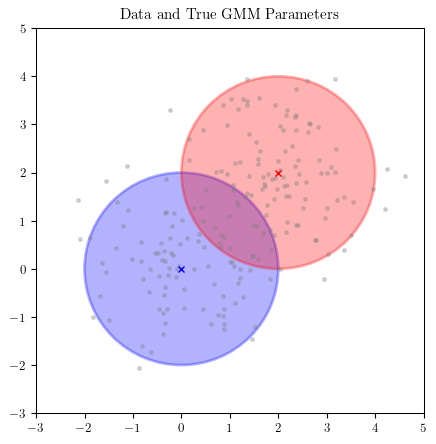

In [2]:
n_components = 2
pi = np.ones(n_components) / n_components
mus = [np.array([0., 0.]), np.array([2., 2.])]
covs = [np.eye(2)]*2

DGP = GaussianMixtureModel(random_state=1234567891)
DGP._set_parameters(mus, covs, pi)

n_samples = 200
X, Z = DGP.sample(n_samples)

plt.figure(figsize=(5,5))
plt.plot(X[:,0], X[:, 1], '.', color='gray', alpha=.3)
DGP.plot_2D_model(plt.gca(), 'br')
plt.title('Data and True GMM Parameters')
plt.xlim([-3, 5])
plt.ylim([-3, 5])
plt.show()

In [3]:
t0 = time()
indices = np.random.choice(n_samples, n_components, replace=False)
initial_theta = [[X[i].copy() for i in indices],
    [np.eye(2) for _ in range(n_components)],
    np.ones(n_components) / n_components]
GMM = GaussianMixtureModel()
GMM.fit(X, initial_theta=initial_theta)
t1 = time()
naive_time = t1-t0

 40%|████      | 202/500 [00:04<00:06, 48.38it/s]


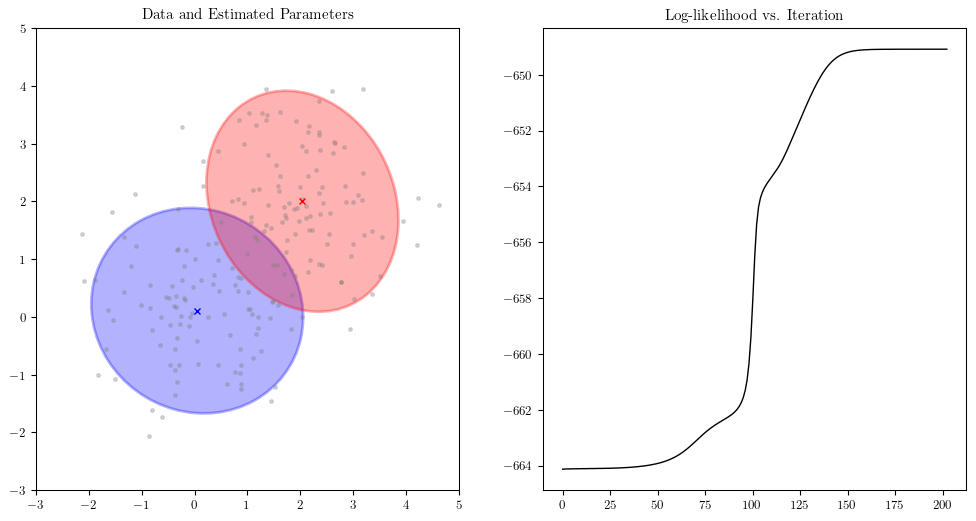

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(X[:,0], X[:, 1], '.', color='gray', alpha=.3)
GMM.plot_2D_model(axs[0], 'br')
axs[0].set_title('Data and Estimated Parameters')
axs[0].set_xlim([-3, 5])
axs[0].set_ylim([-3, 5])

axs[1].plot(GMM.log_likelihoods_, c='k')
axs[1].set_title('Log-likelihood vs. Iteration')
plt.show()

In [28]:
# TO DO: implement this before running! ## expect 50~200
# reimport GaussianMixtureModelVectorized
import importlib
importlib.reload(importlib.import_module('vectorized_em_algorithm'))
from vectorized_em_algorithm import GaussianMixtureModelVectorized

t0 = time()
GMM2 = GaussianMixtureModelVectorized()
GMM2.fit(X, initial_theta=initial_theta)
t1 = time()
vectorized_time = t1-t0

print(f"Vectorized code was {naive_time / vectorized_time:.2f} times faster!")

 40%|████      | 202/500 [00:00<00:00, 4830.14it/s]

Vectorized code was 92.00 times faster!


In [32]:
assert np.allclose(GMM.mu_, GMM2.mu_, atol=1e-6)

## Exercise 2: Make the Method Numerically Stable

Recall from lecture that the normalizing constant $\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)$ in the responsibilities can be very small if $\mathbf{x}_i$ is far from every cluster. This leads to divide by zero errors in the E-step.

Implement the log-sum-exp trick in `GaussianMixtureModelVectorized` to compute both the responsibilities in `_e_step` and the log-likelihood in `_compute_log_likelihood`. These will both be necessary for Exercise 3.

multivariate_pdf in naiveEM

In [33]:
n_features = 50
n_components = 2
pi = np.ones(n_components) / n_components
covs = [np.eye(n_features)]*2

for scale in [.5, 1, 5, 50]:
    mus = [-scale*np.random.rand(n_features), scale*np.random.rand(n_features)]

    DGP = GaussianMixtureModel(random_state=1234567891)
    DGP._set_parameters(mus, covs, pi)

    n_samples = 200
    X, Z = DGP.sample(n_samples)

    GMM = GaussianMixtureModel()
    GMM2 = GaussianMixtureModelVectorized()

    GMM._set_parameters([np.zeros(n_features)]*2, covs, pi)
    GMM2._set_parameters([np.zeros(n_features)]*2, covs, pi)
    print(GMM.score(X), GMM2.score(X))

-14568.858527853377 -4466.5407498761015
-15877.597155616788 -4466.5407498761015
-54626.01187738302 -4466.5407498761015
-inf -4466.5407498761015


/Users/siyuxie/Documents/25Fall/607/studio11/naive_em_algorithm.py:240: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(point_likelihood)


## Exercise 3: Document the Folk Theorem

The model identifiability of a GMM depends on the cluster separation, e.g. $\|\mu_1-\mu_2\|$. When mixture components are harder to distinguish statistically (small separation), the Folk Theorem suggests EM will run into a range of problems:
- More iterations/more time to converge (slow convergence)
- Higher variance in convergence time across initializations (sensitivity to initialization)
- Greater sensitivity e.g. in final log-likelihood to random initialization (getting stuck in local optima)

Generate datasets with varying separations, run EM multiple times (e.g. 20-30 runs) at each separation with different random initializations, and plot each of these metrics as a function of separation.

In [34]:
def generate_data_with_separation(separation, n_samples=200, n_features=2, random_state=None):
    """
    Generate 2D data from two Gaussian components with specified separation.
    
    Parameters
    ----------
    separation : float
        Distance between component means (Euclidean distance)
    n_samples : int, default=200
        Total number of samples to generate
    n_features : int, default=2
        Dimensionality
    random_state : int or None, default=None
        Random seed for reproducibility
    
    Returns
    -------
    X : array, shape (n_samples, 2)
        Generated data points
    true_labels : array, shape (n_samples,)
        True component assignments (0 or 1)
    """
    # Create a GMM with known parameters
    DGP = GaussianMixtureModelVectorized(n_components)
    
    # Set true parameters manually
    mu1 = np.zeros(n_features)
    mu2 = separation * np.ones(n_features) / np.sqrt(n_features)
    
    cov = np.eye(n_features)
    
    DGP.mu_ = np.array([mu1, mu2])
    DGP.cov_ = np.array([cov]*2)
    DGP.pi_ = np.array([0.5, 0.5])
    
    # Sample from the GMM
    X, Z = DGP.sample(n_samples=n_samples, random_state=random_state)
    
    return X, Z

  0%|          | 2/500 [00:00<00:00, 3490.89it/s]


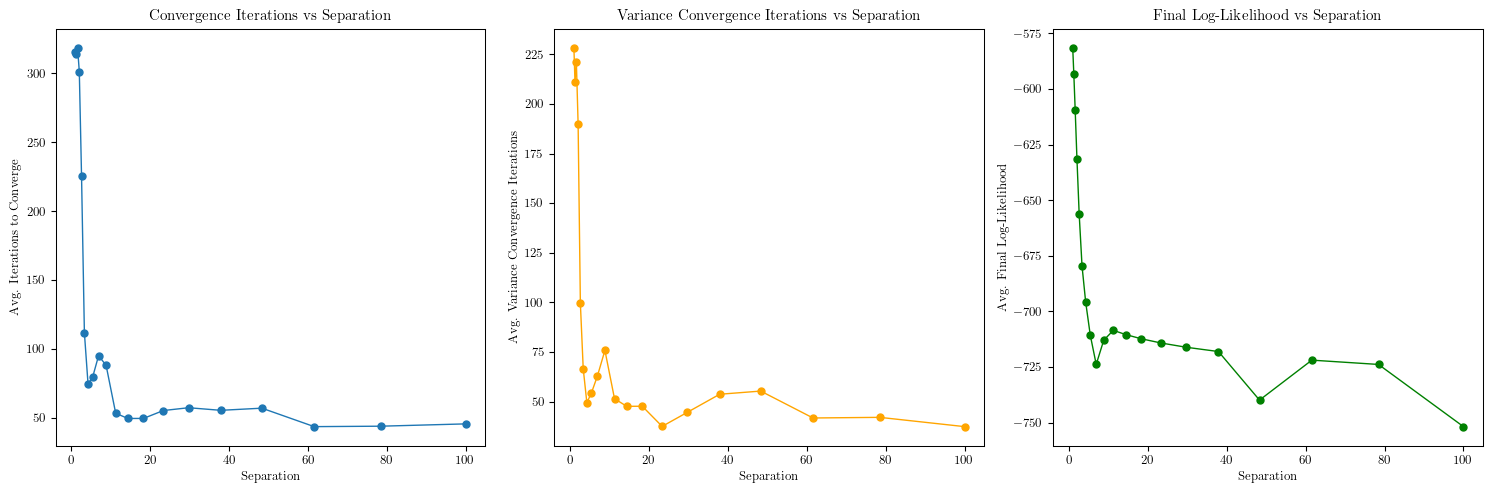

In [38]:
'''
Generate datasets with varying separations, 
run EM multiple times (e.g. 20-30 runs) at each separation 
with different random initializations, 
and plot each of these metrics as a function of separation.
'''

separations = np.logspace(0, 2, 20)  # From 1 to 100
convergence_iterations = []
variance_convergence_iterations = []
final_log_likelihoods = []

for sep in separations:
    iter_counts = []
    var_iter_counts = []
    final_lls = []
    
    for run in range(25):
        X, Z = generate_data_with_separation(sep, n_samples=200, n_features=2, random_state=run)
        
        # Random initialization
        indices = np.random.choice(X.shape[0], n_components, replace=False)
        initial_theta = [[X[i].copy() for i in indices],
                         [np.eye(2) for _ in range(n_components)],
                         np.ones(n_components) / n_components]
        
        GMM = GaussianMixtureModelVectorized()
        GMM.fit(X, initial_theta=initial_theta)
        
        iter_counts.append(len(GMM.log_likelihoods_))
        final_lls.append(GMM.log_likelihoods_[-1])
        
        # Variance convergence criterion
        var_iter = next((i for i in range(1, len(GMM.log_likelihoods_)) 
                         if abs(GMM.log_likelihoods_[i] - GMM.log_likelihoods_[i-1]) < 1e-4), 
                        len(GMM.log_likelihoods_))
        var_iter_counts.append(var_iter)
    
    convergence_iterations.append(np.mean(iter_counts))
    variance_convergence_iterations.append(np.mean(var_iter_counts))
    final_log_likelihoods.append(np.mean(final_lls))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(separations, convergence_iterations, marker='o')
plt.xlabel('Separation')
plt.ylabel('Avg. Iterations to Converge')
plt.title('Convergence Iterations vs Separation')
plt.subplot(1, 3, 2)
plt.plot(separations, variance_convergence_iterations, marker='o', color='orange')
plt.xlabel('Separation')
plt.ylabel('Avg. Variance Convergence Iterations')
plt.title('Variance Convergence Iterations vs Separation')
plt.subplot(1, 3, 3)
plt.plot(separations, final_log_likelihoods, marker='o', color='green')
plt.xlabel('Separation')
plt.ylabel('Avg. Final Log-Likelihood')
plt.title('Final Log-Likelihood vs Separation')
plt.tight_layout()
plt.show()